# Backtesting and benchmarking of the trading strategies


In [ ]:
import sys

sys.path.append("..")

In [ ]:
import pandas as pd

from agents.drl_agent import DRLAgent
from benchmark.portfolio_benchmark import PortfolioBenchmark
from config import config
from environments.env_portfolio_optimisation import (
    PortfolioOptimisationEnvWrapper,
)
from environments.env_stock_trading import StockTradingEnvWrapper
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.benchmark_visualiser import BenchmarkVisualiser

In [ ]:
USE_CASE = "portfolio-optimisation"

In [ ]:
import os

if not os.path.exists(f"../{config.RESULTS_DIR}/{USE_CASE}"):
    os.makedirs(f"../{config.RESULTS_DIR}/{USE_CASE}")

In [ ]:
finpreprocessor = FinancialDataPreprocessor(config.START_DATE, config.END_DATE)
train_data, trade_data = finpreprocessor.load_train_test_data(
    f"../{config.DATA_DIR}", config.TICKERS_NAME
)

In [ ]:
if USE_CASE == "stock-trading":
    environment = StockTradingEnvWrapper(
        train_data,
        trade_data,
        config.ENVIRONMENT_COLUMNS,
    )
elif USE_CASE == "portfolio-optimisation":
    environment = PortfolioOptimisationEnvWrapper(
        train_data,
        trade_data,
        config.ENVIRONMENT_COLUMNS,
    )

Environment successfully created with 
	Stock dimension: 5 
	State space: 14


## Backtest the algorithms


In [ ]:
perf_stats = dict()
df_account = pd.DataFrame()

In [ ]:
benchmark = PortfolioBenchmark()

In [ ]:
for model_name in config.MODELS:

    env_train = environment.get_train_env()
    gym_env, _ = environment.get_trade_env()

    agent = DRLAgent()

    print(f"Loading model: {model_name.upper()}")
    trained_model = agent.load_model(
        model_name,
        f"../{config.MODELS_DIR}/{USE_CASE}",
        config.TICKERS_NAME,
    )

    print(f"Evaluating model: {model_name.upper()}")
    df_account_alg, _ = agent.predict(trained_model, gym_env)

    # Add cumulative returns to the account dataframe
    df_account_alg["cumulative_return"] = (
        1 + df_account_alg["daily_return"]
    ).cumprod() - 1

    df_account_alg["model"] = model_name.upper()

    df_account = pd.concat([df_account, df_account_alg], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account_alg)

    perf_stats[model_name.upper()] = perf_stats_alg  # type: ignore

Loading model: A2C
Model successfully loaded from ../models/portfolio-optimisation/test_a2c
Evaluating model: A2C
Loading model: PPO
Model successfully loaded from ../models/portfolio-optimisation/test_ppo
Evaluating model: PPO
Loading model: DDPG
Model successfully loaded from ../models/portfolio-optimisation/test_ddpg
Evaluating model: DDPG
Loading model: TD3
Model successfully loaded from ../models/portfolio-optimisation/test_td3
Evaluating model: TD3
Loading model: SAC
Model successfully loaded from ../models/portfolio-optimisation/test_sac
Evaluating model: SAC


In [ ]:
benchmark.set_data(train_data, trade_data)

Test start date is not a trading date in the dataset.
Using next available trading date: 2024-01-02


In [ ]:
for strategy in ["mean", "min", "momentum", "equal"]:
    print(f"Optimising portfolio with strategy: {strategy}")

    df_account_strat = benchmark.optimise_portfolio(
        strategy=strategy,  # type: ignore
    )

    # Add cumulative returns to the account dataframe
    df_account_strat["cumulative_return"] = (
        1 + df_account_strat["daily_return"]
    ).cumprod() - 1

    df_account_strat["model"] = strategy.capitalize()
    df_account = pd.concat([df_account, df_account_strat], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account_strat)
    perf_stats[strategy.capitalize()] = perf_stats_alg  # type: ignore

Optimising portfolio with strategy: mean
Optimising portfolio with strategy: min
Optimising portfolio with strategy: momentum
Optimising portfolio with strategy: equal


In [ ]:
perf_stats = pd.DataFrame(perf_stats)
perf_stats.to_csv(
    f"../{config.RESULTS_DIR}/{USE_CASE}/performance_stats_{config.TICKERS_NAME}.csv",
    index=True,
)

In [ ]:
perf_stats

,A2C,PPO,DDPG,TD3,SAC,Mean,Min,Momentum,Equal
Annual return,0.176237,0.197090,0.206446,0.192334,0.192737,0.099219,0.231437,0.107747,0.201553
Cumulative returns,0.272398,0.306021,0.321199,0.298327,0.298978,0.150300,0.360895,0.163533,0.312297
Annual volatility,0.180298,0.175861,0.169842,0.188870,0.187647,0.189880,0.168299,0.187071,0.176047
Sharpe ratio,0.989861,1.110311,1.189666,1.025093,1.032365,0.593116,1.321062,0.640436,1.130472
Calmar ratio,0.900325,1.118895,1.282372,0.957543,0.969007,0.503223,1.484302,0.532133,1.144079
Stability,0.762132,0.804428,0.831217,0.781749,0.783999,0.015406,0.828357,0.246793,0.803438
Max drawdown,-0.195748,-0.176147,-0.160988,-0.200862,-0.198901,-0.197167,-0.155923,-0.202480,-0.176170
Omega ratio,1.217543,1.245809,1.262980,1.229528,1.231124,1.117227,1.290202,1.130553,1.250913
Sortino ratio,1.467883,1.657241,1.772813,1.536948,1.547609,0.822306,1.952544,0.887481,1.687601
Skew,1.022363,1.144584,0.825470,1.200391,1.205975,-0.112014,0.617967,0.020115,1.139661


## Visually compare portfolio value and cumulative returns


In [ ]:
benchmark_visualiser = BenchmarkVisualiser()

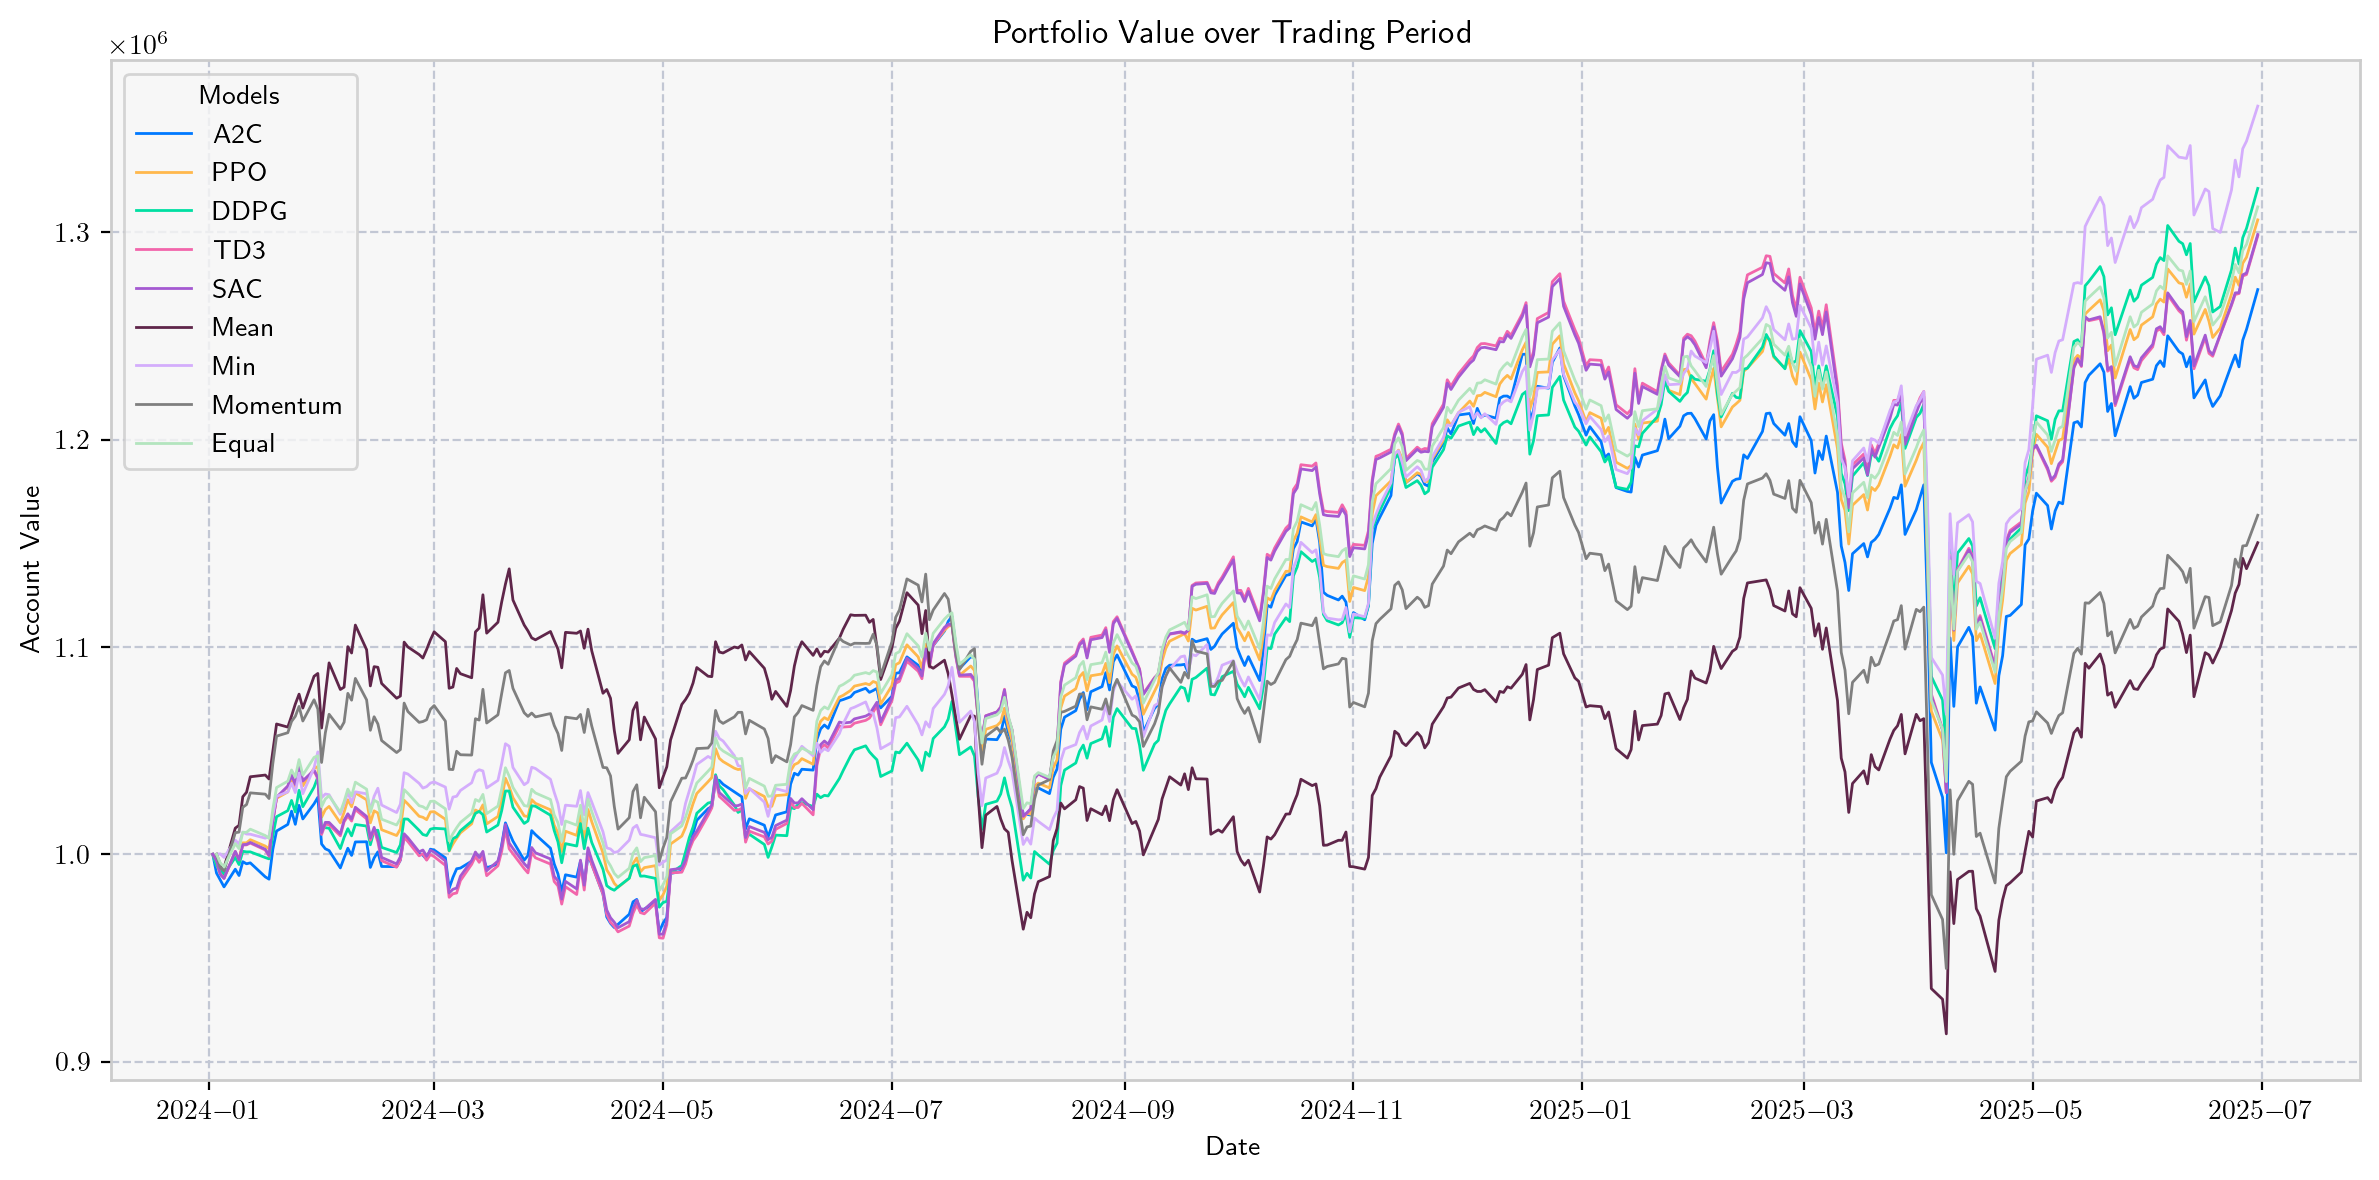

In [ ]:
benchmark_visualiser.compare_account_value(
    df_account, f"../{config.PLOT_DIR}", f"{config.TICKERS_NAME}_{USE_CASE}"
)

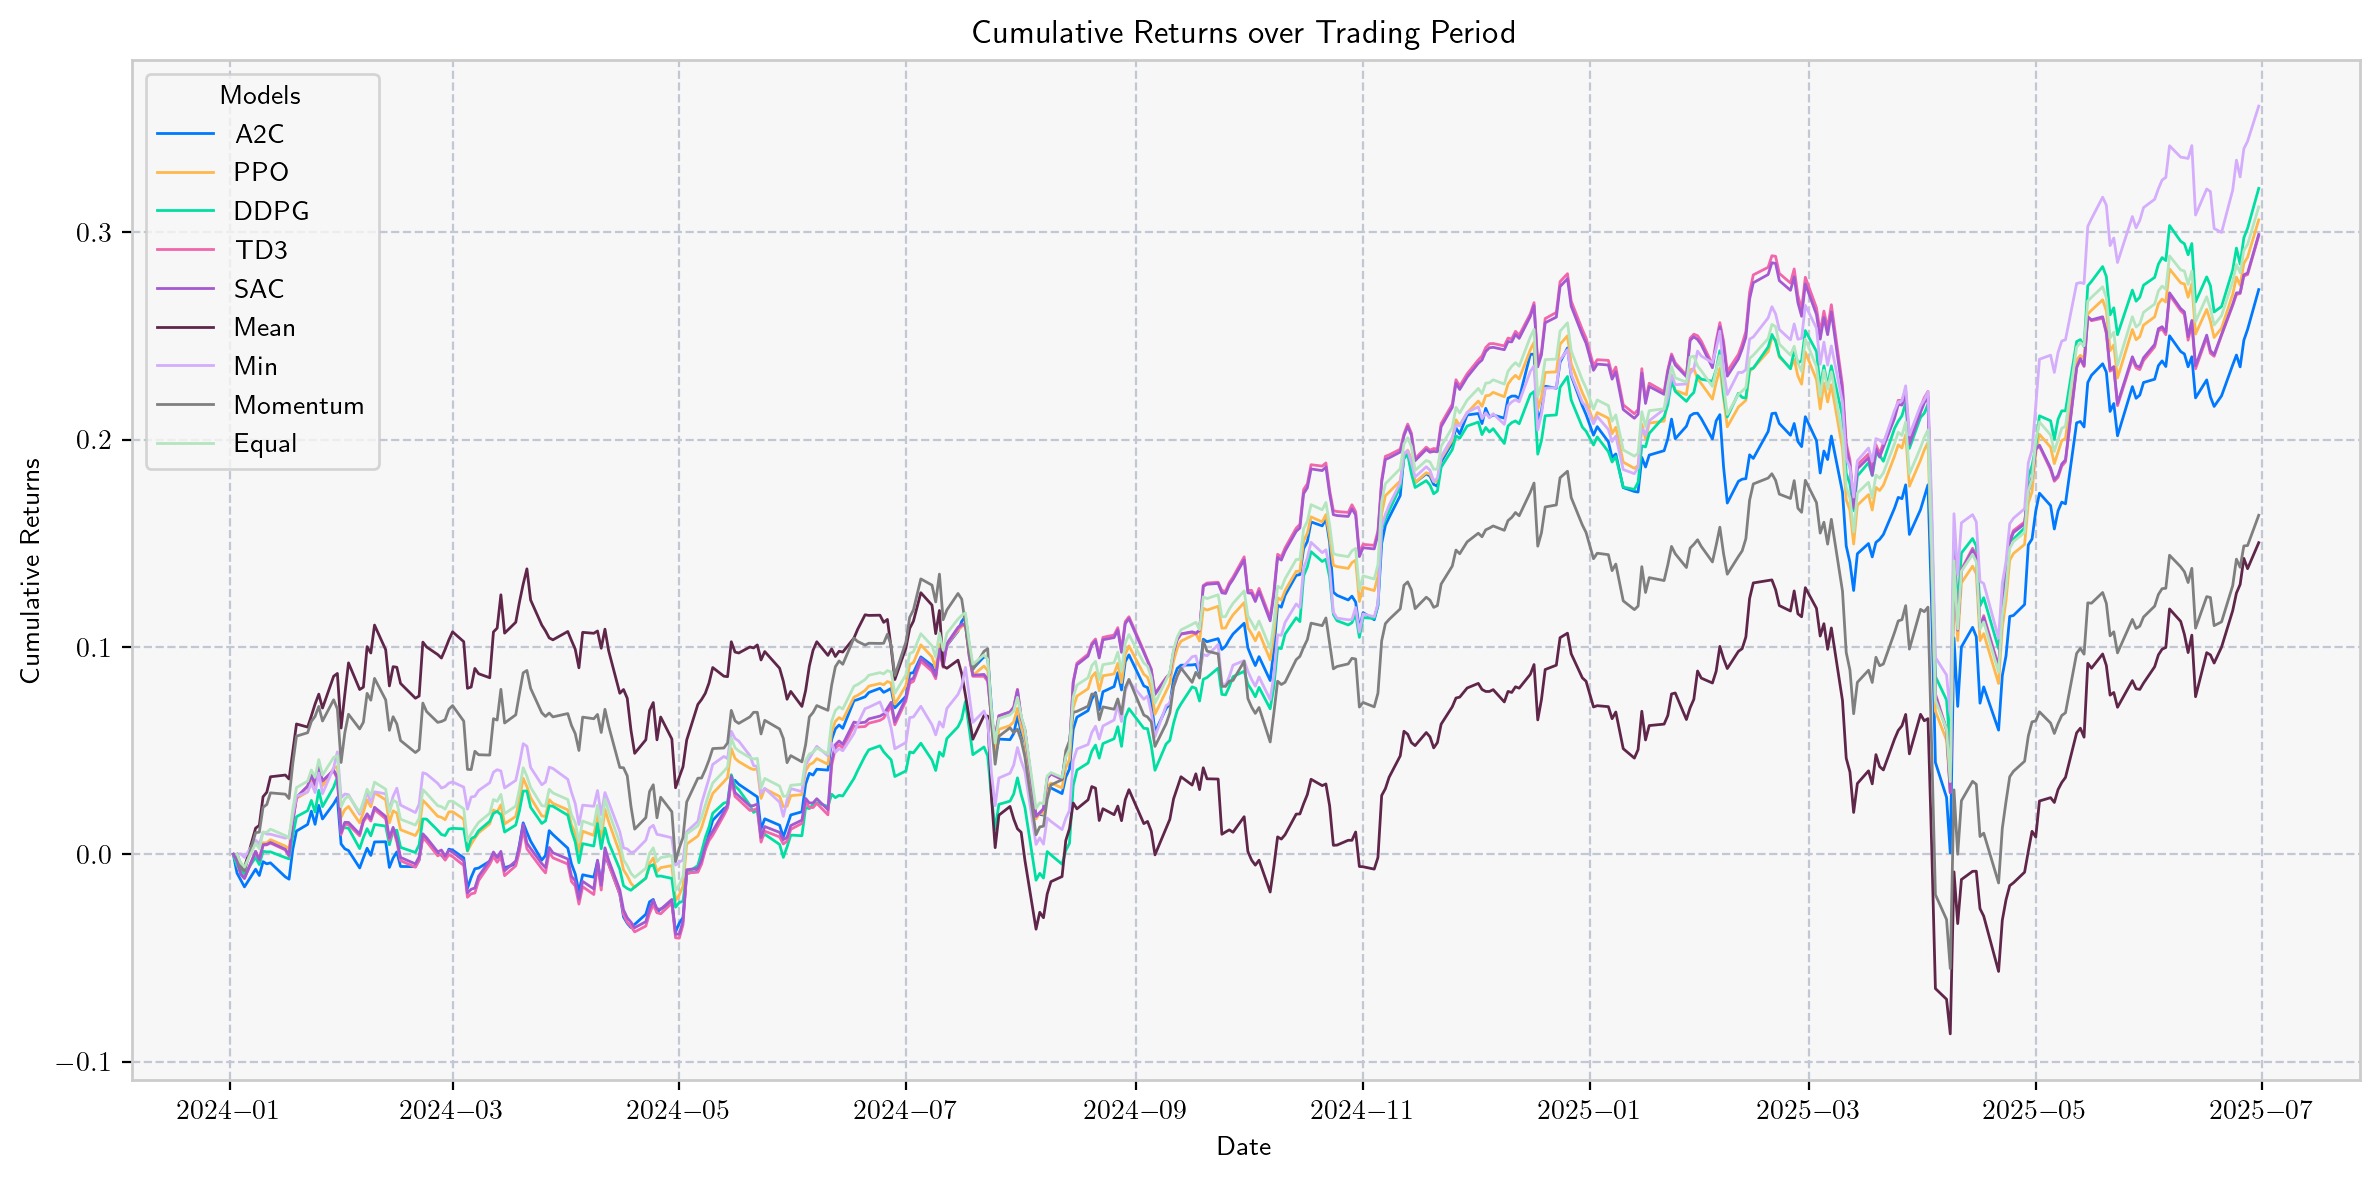

In [ ]:
benchmark_visualiser.compare_cum_returns(
    df_account, f"../{config.PLOT_DIR}", f"{config.TICKERS_NAME}_{USE_CASE}"
)